<a href="https://colab.research.google.com/github/rahiakela/genai-research-and-practice/blob/main/hands-on-generative-ai-with-transformers-and-diffusion-models/06_finetuning_stable_diffusion_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
%%capture

!pip install genaibook
!pip install datasets

In [ ]:
import datasets

import torch

from huggingface_hub.repocard import RepoCard

from diffusers import StableDiffusionPipeline
from diffusers import DiffusionPipeline

from datasets import load_dataset

from genaibook.core import get_device

import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from tqdm import tqdm

In [4]:
device = get_device()

## Dataset

In [ ]:
esa_hubble = load_dataset("Supermaxman/esa-hubble")

In [ ]:
esa_hubble

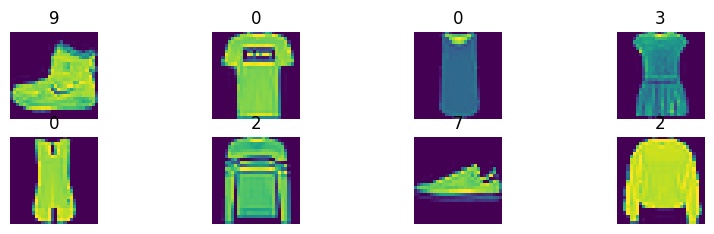

In [ ]:
clothes = fashion_mnist["train"]["image"][:8]
classes = fashion_mnist["train"]["label"][:8]

show_images(clothes, titles=classes, figsize=(10, 2.5))

In [ ]:
# Define transformations
preprocess = transforms.Compose(
   [
      transforms.RandomHorizontalFlip(),            # Randomly flip (data augmentation)
      transforms.ToTensor(),                        # Convert to tensor (0, 1)
      transforms.Pad(2),                            # Add 2 pixels on all sides
      transforms.Normalize([0.5], [0.5]),           # Map to (-1, 1)
   ]
)

In [ ]:
def transform(examples):
  images = [preprocess(image) for image in examples["image"]]
  return {"images": images, "labels": examples["label"]}

train_dataset = fashion_mnist["train"].with_transform(transform)

In [ ]:
batch_size = 256

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

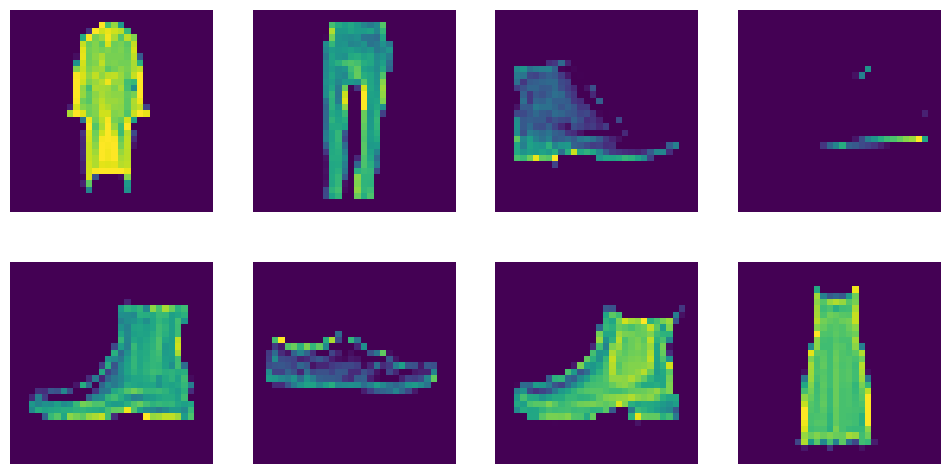

In [ ]:
# let's load a batch and inspecting the images
batch = next(iter(train_dataloader))

# When we normalized, we mapped (0, 1) to (-1, 1)
# Now we map back to (0, 1) for display
show_images((batch["images"][:8] * 0.5 * 0.5).clip(0, 1))

##Class-Conditioned Model

In [ ]:
# let's create a UNet and feed our batch of noisy images through it
model = UNet2DModel(
    sample_size=32, # Specify our input size
    in_channels=1,  # 1 channel for grayscale images
    out_channels=1, # 1 channel for grayscale images
    block_out_channels=(32, 64, 128, 256), # How many channels each block will have
    num_class_embeds=10, # Enable class conditioning
)

In [ ]:
# Pass a batch of data and the class labels as additional through to make sure it works
x = torch.randn((1, 1, 32, 32))
with torch.inference_mode():
  output = model(x, timestep=7, class_labels=torch.tensor([2])).sample
print(output.shape)

torch.Size([1, 1, 32, 32])


###Training

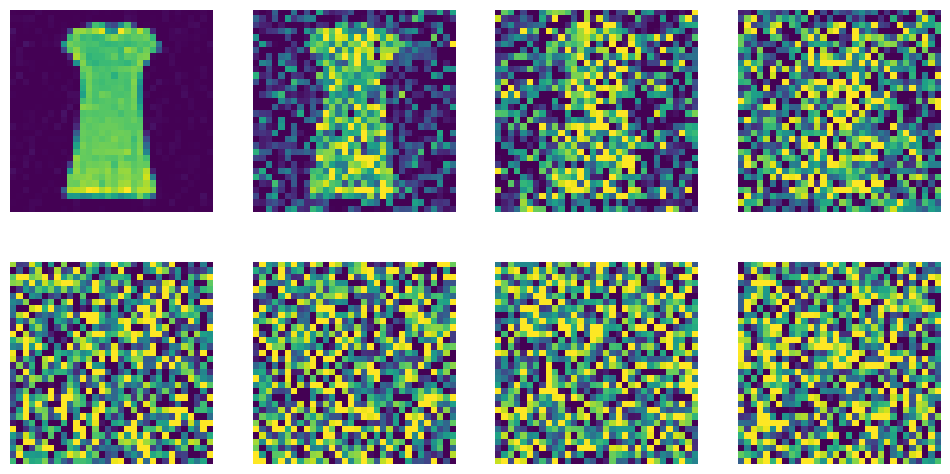

In [ ]:
# Initialize the scheduler
scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_start=0.001,
    beta_end=0.02,
)

# Sample a random timestep for each image
timesteps = torch.linspace(0, 999, 8).long()
batch = next(iter(train_dataloader))

# We load 8 images from the dataset and add increasing amounts of noise to them
x = batch["images"][0].expand([8, 1, 32, 32])
noise = torch.randn_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)

show_images((noised_x * 0.5 + 0.5).clip(0, 1))

In [ ]:
num_epochs = 25 # How many runs through the data should we do?
lr = 3e-4       # What learning rate should we use
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)
losses = []     # Somewhere to store the loss values for later plotting

model = model.to(device)

# Train the model (this takes a while)
for epoch in (progress := tqdm(range(num_epochs))):
  for step, batch in (inner := tqdm(enumerate(train_dataloader), position=0, leave=True, total=len(train_dataloader))):
    # Load the input images
    clean_images = batch["images"].to(device)
    class_lebels = batch["labels"].to(device)

    # Sample noise to add to the images
    noise = torch.randn(clean_images.shape).to(device)

    # Sample a random timestep for each image
    timesteps = torch.randint(
        0,
        scheduler.config.num_train_timesteps,
        (clean_images.shape[0],),
        device=device,
    ).long()

    # Add noise to the clean images according to the noise magnitude at each timestep
    noisy_images = scheduler.add_noise(clean_images, noise, timesteps)

    # Get the model prediction for the noise
    # The model also uses the timestep as an input for additional conditioning
    # Note the use of class_labels
    noise_pred = model(noisy_images, timesteps, class_labels=class_lebels, return_dict=False)[0]

    # Compare the prediction with the actual noise
    loss = F.mse_loss(noise_pred, noise)

    # Update loss display
    inner.set_postfix(loss=f"{loss.cpu().item():03f}")

    # Store the loss for later plotting
    losses.append(loss.item())

    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

 58%|█████▊    | 137/235 [01:35<01:08,  1.43it/s, loss=0.023526]

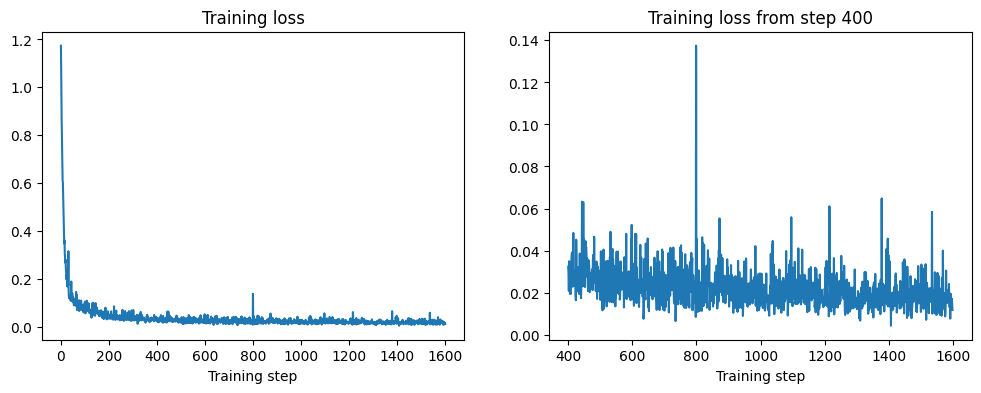

In [ ]:
plt.plot(losses)
plt.title("Training loss")
plt.xlabel("Training step");

###Sampling

We now have a model that expects two inputs when making predictions:

1. the image
2. the class label

  0%|          | 0/1000 [00:00<?, ?it/s]

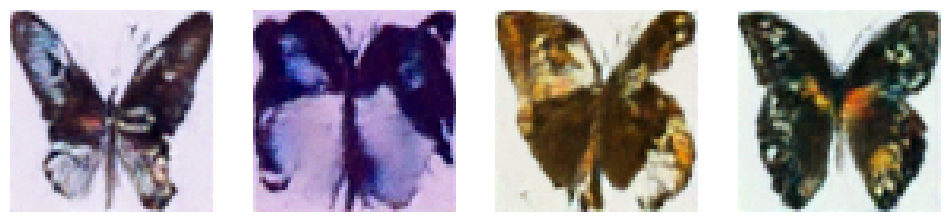

In [ ]:
def generate_from_class(class_to_generate, n_samples=8):
    sample = torch.randn(n_samples, 1, 32, 32).to(device)
    class_labels = [class_to_generate] * n_samples
    class_labels = torch.tensor(class_labels).to(device)

    for _, t in tqdm(enumerate(scheduler.timesteps)):
        # Get model prediction
        with torch.inference_mode():
            noise_pred = model(sample, t, class_labels=class_labels).sample

        # Update sample with step
        sample = scheduler.step(noise_pred, t, sample).prev_sample

    return sample.clip(-1, 1) * 0.5 + 0.5

# let’s do inference and generate some t-shirts (class 0)
images = generate_from_class(0)
show_images(images, nrows=2)

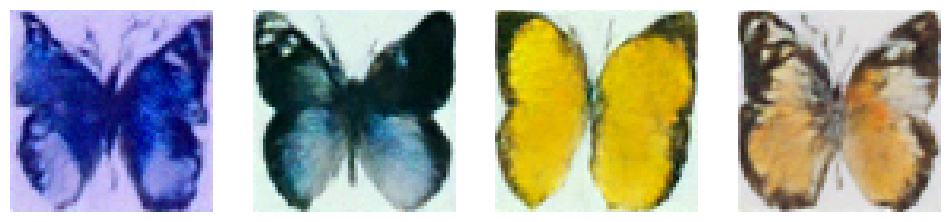

In [ ]:
# let’s generate some sneakers (class 7)
images = generate_from_class(7)
show_images(images, nrows=2)

In [ ]:
# let’s generate some boots (class 9)
images = generate_from_class(7)
show_images(images, nrows=2)

In [ ]:
# let’s generate some frock (class 3)
images = generate_from_class(3)
show_images(images, nrows=2)

##Stable Diffusion: Components in Depth

In [ ]:
from diffusers import StableDiffusionPipeline
import torch

model_id = "sd-legacy/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

In [ ]:
pipe("Watercolor illustration of a rose").images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

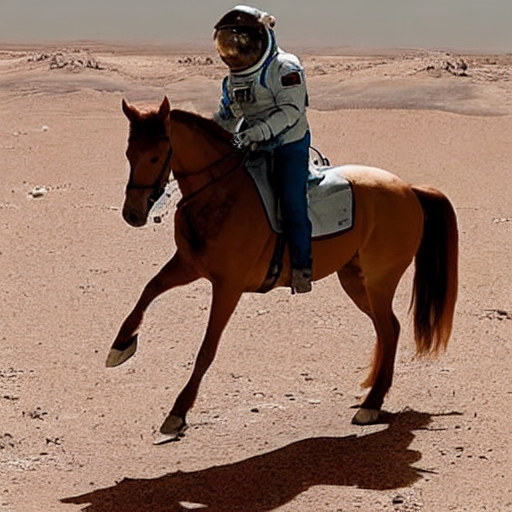

In [ ]:
prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt).images[0]
image

In [ ]:

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
)
pipe.to("cuda")

model_index.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

StableDiffusionInpaintPipeline {
  "_class_name": "StableDiffusionInpaintPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "stabilityai/stable-diffusion-2-inpainting",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
!wget https://machinelearningmastery.com/wp-content/uploads/2024/04/inpaint-example.png
!wget https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png

In [ ]:
image = Image.open("inpaint-example.png").convert("RGB")
mask_image = Image.open("overture-creations-5sI6fQgYIuo_mask.png")

  0%|          | 0/50 [00:00<?, ?it/s]

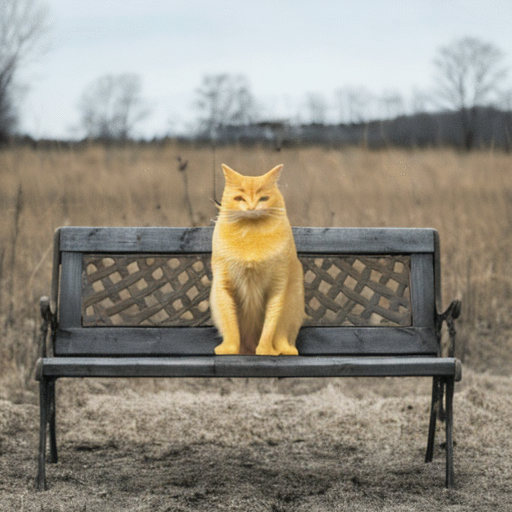

In [ ]:
prompt = "Face of a yellow cat, high resolution, sitting on a park bench"
image = pipe(prompt=prompt, image=image, mask_image=mask_image).images[0]
image

###Text Encoder

In [ ]:
prompt = "A photograph of a puppy"

# Turn the text into a sequence of tokens
text_input = pipe.tokenizer(
    prompt,
    return_tensors="pt",
)

# Output each token and its corresponding ID
for t in text_input["input_ids"][0]:
    print(f"{t}: {pipe.tokenizer.decoder.get(int(t))}")

49406: <|startoftext|>
320: a</w>
8853: photograph</w>
539: of</w>
320: a</w>
6829: puppy</w>
49407: <|endoftext|>


In [ ]:
text_embeddings = pipe.text_encoder(text_input.input_ids.to(device))[0]
print(f"Text embeddings shape: {text_embeddings.shape}")

Text embeddings shape: torch.Size([1, 7, 768])


###Variational AutoEncoder

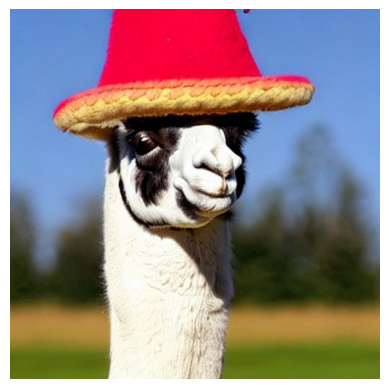

In [ ]:
img = load_image(SampleURL.LlamaExample, size=(512, 512))
show_image(img);

In [ ]:
with torch.inference_mode():
  # Process image
  tensor_im = transforms.ToTensor()(img).unsqueeze(0).to(device) * 2 - 1
  tensor_im = tensor_im.half() # convert from float32 to float16

  # Encode image
  latent = pipe.vae.encode(tensor_im)

  # Sample from the latent distribution
  latents = latent.latent_dist.sample()
  latents = latents * 0.18215 # Scale the latent vector
print(latents.shape)

torch.Size([1, 4, 64, 64])


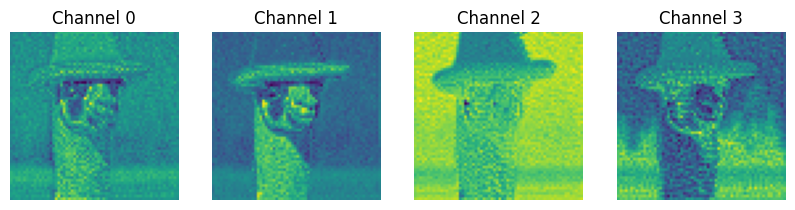

In [ ]:
show_images(
    [l.cpu() for l in latents[0]],
    titles=[f"Channel {i}" for i in range(latents.shape[1])],
    ncols=4,
    figsize=(10, 2.5)
)

<Axes: >

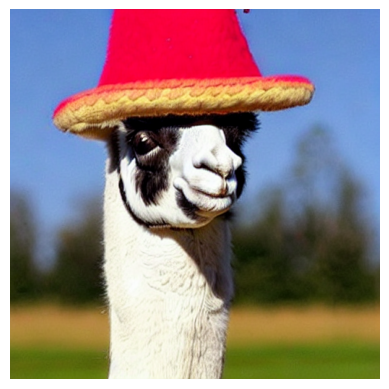

In [ ]:
with torch.inference_mode():
  # Decode the latent image
  image = pipe.vae.decode(latents / 0.18215).sample
image = (image / 2 + 0.5).clamp(0, 1)
show_image(image[0].float())

### Classifier-free guidance

In [ ]:
images = []
prompt = "An oil painting of a Llama in a top hat"

mask_image = Image.open("overture-creations-5sI6fQgYIuo_mask.png")

for guidance_scale in [1, 2, 4, 12]:
    torch.manual_seed(0)
    image = pipe(prompt, image=img, mask_image=mask_image, guidance_scale=guidance_scale).images[0]
    images.append(image)

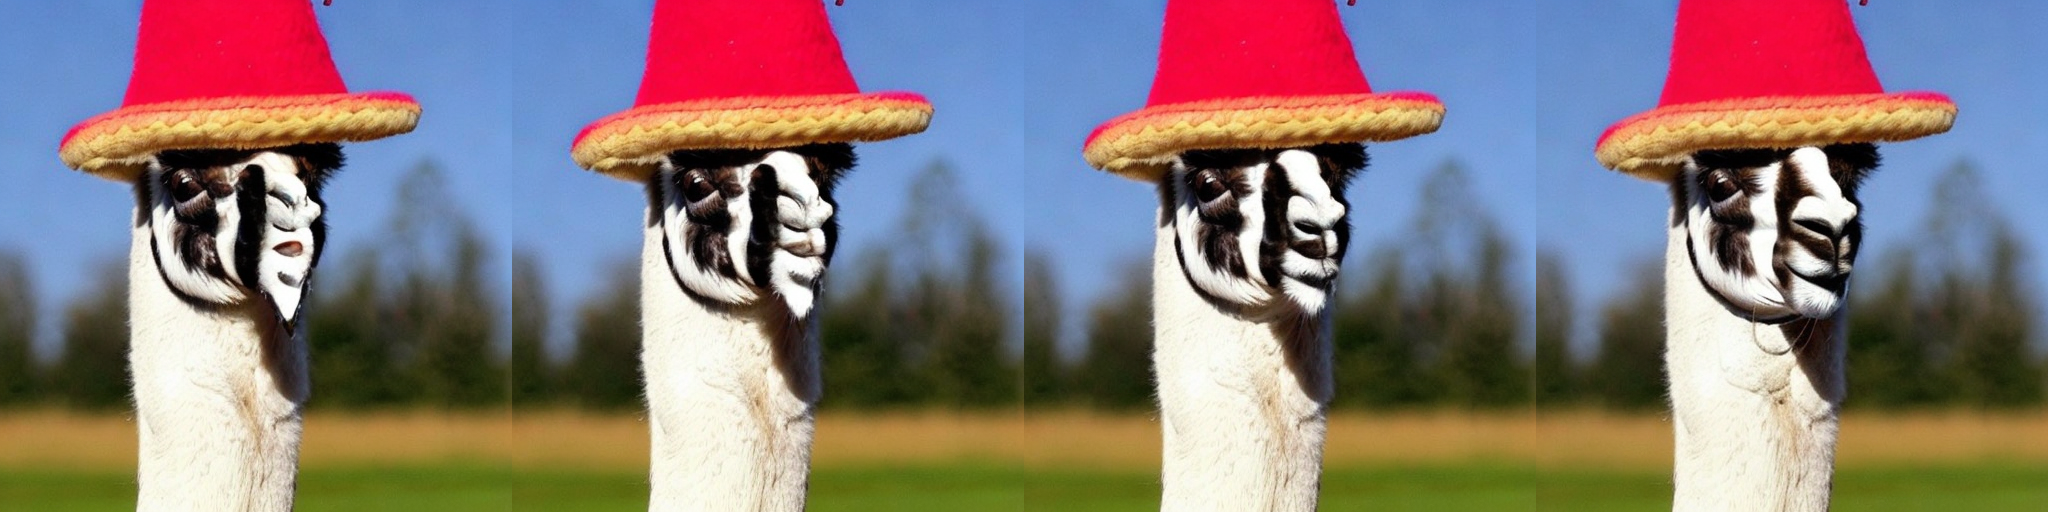

In [ ]:
from genaibook.core import image_grid

image_grid(images, 1, 4)

##Putting it All Together

In [ ]:
# Some settings
prompt = [
    "Acrylic palette knife painting of a flower"
]  # What we want to generate
height = 512  # default height of SD
width = 512  # default width of SD
num_inference_steps = 30  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
seed = 42  # Seed for random number generator

In [ ]:
# Tokenize the input
text_input = pipe.tokenizer(
    prompt,
    padding="max_length",  # Pad to max length to ensure both inputs have the same shape
    return_tensors="pt",
)

# Do the same for the unconditional input (a blank string)
uncond_input = pipe.tokenizer(
    "",
    padding="max_length",
    return_tensors="pt",
)

# Feed both embeddings through the text encoder
with torch.inference_mode():
    text_embeddings = pipe.text_encoder(text_input.input_ids.to(device))[0]
    uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(device))[0]

# Concatenate the two sets of text embeddings embeddings
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [ ]:
# Prepare the scheduler
pipe.scheduler.set_timesteps(num_inference_steps)

# Prepare the random starting latents
latents = (
    torch.randn(
        (1, pipe.vae.config.in_channels, height // 8, width // 8),
    )
    .to(device)
    .half()
)
latents = latents * pipe.scheduler.init_noise_sigma

In [ ]:
for t in pipe.scheduler.timesteps:
    # Create two copies of the latents to match the two
    # text embeddings (unconditional and conditional)
    latent_input = torch.cat([latents] * 2)
    latent_input = pipe.scheduler.scale_model_input(latent_input, t)

    # Predict noise residuals for both unconditional and conditional latents
    with torch.inference_mode():
        noise_pred = pipe.unet(
            latent_input, t, encoder_hidden_states=text_embeddings
        ).sample

    # Split the prediction into unconditional and conditional versions
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)

    # Perform classifier-free guidance
    noise_pred = noise_pred_uncond + guidance_scale * (
        noise_pred_text - noise_pred_uncond
    )

    # Update latents for the next timestep
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

In [ ]:
# Scale and decode the image latents with the VAE
latents = 1 / pipe.vae.config.scaling_factor * latents
with torch.inference_mode():
    image = pipe.vae.decode(latents).sample
image = (image / 2 + 0.5).clamp(0, 1)

show_image(image[0].float());